# LDA 

In [1]:
import pandas as pd
from gensim import corpora
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

wine_df = pd.read_csv('Cleaned_Wine_with_Reviewer.csv')

In [2]:
wine_df.drop_duplicates(subset=['clean_review'], inplace=True) 
descriptions = wine_df['clean_review']

In [3]:
from string import punctuation
stop_words = set(stopwords.words('english')) 
stop_words = stop_words.union(set(punctuation)) 
stop_words.update(["\'s", "n't"])
stop_words.add('wine')
stop_words.add('flavor')
stop_words.add('drink')
stop_words.add('palate')

Had to add a lot of extra stop words after multiple runs through my LDA model.

In [4]:
lemmatizer = WordNetLemmatizer()
texts = [[lemmatizer.lemmatize(word) for word in word_tokenize(description.lower()) if word not in stop_words] for description in descriptions]

In [5]:
print(texts[4])

['dry', 'restrained', 'spice', 'profusion', 'balanced', 'acidity', 'firm', 'texture', 'much', 'food']


I lemmatize remaining words. I prefer to lemmatize it over stemming, so I can actually look at the resulting topics/features and understand what they are.

In [6]:
import gensim

# Build the bigram and trigram models
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[texts], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram) 
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [7]:
 print(trigram_mod[bigram_mod[texts[4]]])

['dry', 'restrained', 'spice', 'profusion', 'balanced', 'acidity', 'firm', 'texture', 'much', 'food']


I trained a bi-gram and tri-gram analyzer. Next I replace all identified bi-gram and tri-gram word-pairs and triplets in the text with representations. This makes them single features for algorithms.

In [8]:
texts = [trigram_mod[bigram_mod[text]] for text in texts]

Now I create an id to word mapping for gensim

In [9]:
id2word = corpora.Dictionary(texts)

Sweet. Let's make the model. I'll start with two initial topics.

In [10]:
from gensim.models import LdaModel

corpus = [id2word.doc2bow(text) for text in texts] 
test_lda = LdaModel(corpus,num_topics=2, id2word=id2word) 

In [11]:
 test_lda.print_topics(num_words=20)

[(0,
  '0.022*"aroma" + 0.020*"fruit" + 0.019*"black" + 0.018*"cherry" + 0.015*"tannin" + 0.011*"plum" + 0.011*"berry" + 0.010*"note" + 0.010*"oak" + 0.010*"spice" + 0.009*"red" + 0.008*"dark" + 0.008*"blackberry" + 0.007*"nose" + 0.007*"herb" + 0.007*"cabernet" + 0.007*"blend" + 0.006*"vanilla" + 0.006*"full" + 0.006*"raspberry"'),
 (1,
  '0.026*"fruit" + 0.024*"acidity" + 0.014*"ripe" + 0.013*"apple" + 0.012*"fresh" + 0.009*"crisp" + 0.009*"dry" + 0.009*"citrus" + 0.009*"rich" + 0.009*"white" + 0.008*"lemon" + 0.008*"texture" + 0.008*"light" + 0.007*"note" + 0.007*"red" + 0.007*"tannin" + 0.007*"fruity" + 0.007*"full" + 0.007*"bright" + 0.007*"aroma"')]

If I were to guess, I'd say these two topics are white wine vs. red wine. Cool, this makes a lot more sense than LSA nad NMF. Now I need to figure out how many topics to include in my model. I'll build a coherence value function so I can feed in different number of topics and see how coherence value changes.

In [12]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3): 
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respect """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word) 
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [13]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=40, start=2, step=6)

In [14]:
coherence_values

[0.3496411646725073,
 0.46075853271899203,
 0.44550368927036926,
 0.46533134565623263,
 0.4583933868404214,
 0.42664274246620615,
 0.40737479289662465]

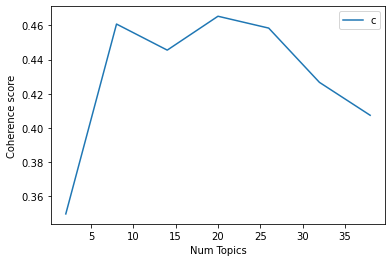

In [15]:
import matplotlib.pyplot as plt 
%matplotlib inline
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values) 
plt.xlabel("Num Topics") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()

In [16]:
print(coherence_values)

[0.3496411646725073, 0.46075853271899203, 0.44550368927036926, 0.46533134565623263, 0.4583933868404214, 0.42664274246620615, 0.40737479289662465]


Looks like it starts to level off after 9 topics. 9 topics it is.

In [17]:
test_lda = LdaModel(corpus,num_topics=9, id2word=id2word) 

In [18]:
test_lda.print_topics(num_words=20)

[(0,
  '0.024*"vineyard" + 0.020*"show" + 0.019*"nose" + 0.018*"cherry" + 0.017*"fruit" + 0.014*"bottling" + 0.014*"black" + 0.011*"cranberry" + 0.010*"aroma" + 0.009*"dried" + 0.009*"raspberry" + 0.009*"tart" + 0.009*"strawberry" + 0.009*"light" + 0.008*"herb" + 0.007*"syrah" + 0.007*"red" + 0.007*"blend" + 0.007*"touch" + 0.007*"spice"'),
 (1,
  '0.029*"lemon" + 0.025*"nose" + 0.023*"apple" + 0.022*"note" + 0.021*"lime" + 0.017*"dry" + 0.016*"citrus" + 0.016*"fresh" + 0.015*"green" + 0.013*"grapefruit" + 0.012*"aroma" + 0.010*"acidity" + 0.010*"pear" + 0.009*"peach" + 0.009*"orange" + 0.009*"clean" + 0.009*"hint" + 0.009*"freshness" + 0.008*"peel" + 0.008*"white"'),
 (2,
  '0.022*"fruit" + 0.012*"long" + 0.009*"yet" + 0.009*"find" + 0.008*"bit" + 0.008*"hint" + 0.008*"time" + 0.007*"seems" + 0.006*"still" + 0.006*"ing" + 0.006*"may" + 0.005*"acid" + 0.005*"little" + 0.005*"note" + 0.005*"bottle" + 0.005*"cherry" + 0.004*"streak" + 0.004*"despite" + 0.004*"complexity" + 0.004*"lovely"

Hmm, not the most intuitive. Let me try to find the top 5 documents for each topic, see if I can deduce anything from it.

In [19]:
import heapq 

top_docs = {} 
n_topics = 9
#first create placeholder lists for top 5 docs in each topic 
for t in range(0, n_topics):
    doc_list = [(-1,-1),(-1,-1),(-1,-1),(-1,-1),(-1,-1)] 
    heapq.heapify(doc_list)
    top_docs[t] = doc_list
#count variable in following is practically doc_id since the index is from 0 with increments of 1
count = 0
for doc in corpus:
    if count % 10000 == 0:
        #this is just to see it progresses, as it sometimes seems slow 
        print(count)
    topics = test_lda[doc] 
    for topic_prob in topics:
        topic_n = topic_prob[0]
        topic_p = topic_prob[1]
        top_list = top_docs[topic_n]
        #count is document id, heapq sorts by first item in tuple
        heapq.heappushpop(top_list, (topic_p, count))
        #above pushes new item, pops lowest item. so pop itself if lowest..
    count += 1

0
10000
20000
30000
40000
50000
60000
70000


In [20]:
print(top_docs)

{0: [(0.96703315, 7606), (0.9682432, 22586), (0.967039, 35645), (0.9693299, 29091), (0.9683149, 78675)], 1: [(0.96293586, 685), (0.9629396, 9088), (0.9712957, 1705), (0.9644405, 3888), (0.96582764, 72972)], 2: [(0.7564871, 50163), (0.7633054, 5359), (0.8499583, 1959), (0.7704992, 12392), (0.85178787, 68783)], 3: [(0.9730519, 16092), (0.973055, 1481), (0.9752947, 62959), (0.9745852, 25485), (0.9759624, 53725)], 4: [(0.95590156, 72249), (0.9576606, 44970), (0.9576591, 35744), (0.96132135, 26599), (0.95957494, 2469)], 5: [(0.9693866, 2895), (0.9713152, 12154), (0.9694149, 13875), (0.97538424, 60900), (0.9721984, 32799)], 6: [(0.977768, 42372), (0.9777686, 23253), (0.9806668, 17414), (0.9783114, 28056), (0.9783085, 28605)], 7: [(0.9505891, 2717), (0.9511824, 43993), (0.9555297, 23809), (0.96705854, 2132), (0.95319194, 817)], 8: [(0.9613344, 70693), (0.96133447, 72323), (0.9613363, 58063), (0.9629291, 945), (0.96295166, 1646)]}


In [21]:
#topic 0: Interesting. All red wines from California, all reviewed by Matt Kettman.
doc_ids = [7606, 22586, 35645, 29091, 78675] 
temp_df = wine_df.iloc[doc_ids, :] 
temp_df.head()

,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review
8703,10693,US,The nose of this bottling is pleasantly earthy...,63,California,Familia Schroeder NV Deseado Sparkling (Argent...,Pinot Noir,Demetria,red,Matt Kettmann,nose bottling pleasantly earthy rustic compost...
25884,32355,US,Blended from Muns Vineyard near the mountainto...,34,California,Waits-Mast 2013 Nash Mill Vineyard Pinot Noir ...,Syrah,Silver Mountain,red,Matt Kettmann,blended muns vineyard near mountaintop wiedeme...
40613,50901,US,"Cherry pie, cherry candy and dried ginger note...",48,California,L. Tramier & Fils 2015 Collection (Saint-Véran),Merlot,Broken Earth,red,Matt Kettmann,cherry pie cherry candy dried ginger notes con...
33270,41480,US,"Light red cherry, dried sage, black tea and th...",45,California,Château Coudray Montpensier 2015 Le Grand Bouq...,Pinot Noir,Edna Valley Vineyard,red,Matt Kettmann,light red cherry dried sage black tea thyme sh...
85968,108026,US,"Black cherry, cola, dried sagebrush and caked ...",40,California,NaN,Rhône-style Red Blend,Margerum,red,Matt Kettmann,black cherry cola dried sagebrush caked lilac ...


In [22]:
top_sorted = {}
for topic_id in top_docs:
    heap = top_docs[topic_id]
    sorted_topics = [heapq.heappop(heap) for _ in range(len(heap))] 
    print(str(topic_id)+": "+str(sorted_topics)) 
    top_sorted[topic_id] = sorted_topics

0: [(0.96703315, 7606), (0.967039, 35645), (0.9682432, 22586), (0.9683149, 78675), (0.9693299, 29091)]
1: [(0.96293586, 685), (0.9629396, 9088), (0.9644405, 3888), (0.96582764, 72972), (0.9712957, 1705)]
2: [(0.7564871, 50163), (0.7633054, 5359), (0.7704992, 12392), (0.8499583, 1959), (0.85178787, 68783)]
3: [(0.9730519, 16092), (0.973055, 1481), (0.9745852, 25485), (0.9752947, 62959), (0.9759624, 53725)]
4: [(0.95590156, 72249), (0.9576591, 35744), (0.9576606, 44970), (0.95957494, 2469), (0.96132135, 26599)]
5: [(0.9693866, 2895), (0.9694149, 13875), (0.9713152, 12154), (0.9721984, 32799), (0.97538424, 60900)]
6: [(0.977768, 42372), (0.9777686, 23253), (0.9783085, 28605), (0.9783114, 28056), (0.9806668, 17414)]
7: [(0.9505891, 2717), (0.9511824, 43993), (0.95319194, 817), (0.9555297, 23809), (0.96705854, 2132)]
8: [(0.9613344, 70693), (0.96133447, 72323), (0.9613363, 58063), (0.9629291, 945), (0.96295166, 1646)]


In [23]:
#topic 1: All white wines, mostly from CA, mostly reviewed by Matt Kettman.
doc_ids = [685,9088,3888, 72972, 1705] 
temp_df = wine_df.iloc[doc_ids, :] 
temp_df.head()

,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review
808,979,Spain,"Clean, peachy aromas set up a light, minerally...",18,Northern Spain,Altos Las Hormigas 2013 Appellation Gualtallar...,White Blend,Gorka Izagirre,white,Michael Schachner,clean peachy aromas set light minerally citrus...
10417,12928,Austria,"Ripe, yellow pear shines through the savory ye...",27,Kremstal,St. Urbans-Hof 2013 Leiwener Laurentiuslay Spä...,Grüner Veltliner,Türk,white,Anne Krebiehl MW,ripe yellow pear shines savory yeast notes nos...
4519,5572,US,"Clean if slightly sweet notes of apple, Meyer ...",37,California,Mogollon 2012 Malbec (Uco Valley),Chardonnay,Hunt Cellars,white,Matt Kettmann,clean slightly sweet notes apple meyer lemon p...
80238,100770,US,"The faintest hint of pink in the glass, this b...",60,California,NaN,Sparkling Blend,Goat Bubbles,white,Matt Kettmann,faintest hint pink glass bottling steely tigh...
1969,2411,US,Playful and nearly effervescent on the nose wi...,20,California,Penley Estate 2012 Special Select Shiraz (Coon...,Grüner Veltliner,Zocker,white,Matt Kettmann,playful nearly effervescent nose lemon lime so...


In [24]:
from IPython.display import display

for topic_id in top_sorted:
    print("Topic:"+str(topic_id))
    top_docs = top_sorted[topic_id]
    doc_ids = [doc_tuple[1] for doc_tuple in top_sorted[topic_id]] 
    doc_weights = [doc_tuple[0] for doc_tuple in top_sorted[topic_id]] 
    temp_df = wine_df.iloc[doc_ids, :]
    temp_df["topic_weight"] = doc_weights 
    display(temp_df.head())


Topic:0


/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review,topic_weight
8703,10693,US,The nose of this bottling is pleasantly earthy...,63,California,Familia Schroeder NV Deseado Sparkling (Argent...,Pinot Noir,Demetria,red,Matt Kettmann,nose bottling pleasantly earthy rustic compost...,0.967033
40613,50901,US,"Cherry pie, cherry candy and dried ginger note...",48,California,L. Tramier & Fils 2015 Collection (Saint-Véran),Merlot,Broken Earth,red,Matt Kettmann,cherry pie cherry candy dried ginger notes con...,0.967039
25884,32355,US,Blended from Muns Vineyard near the mountainto...,34,California,Waits-Mast 2013 Nash Mill Vineyard Pinot Noir ...,Syrah,Silver Mountain,red,Matt Kettmann,blended muns vineyard near mountaintop wiedeme...,0.968243
85968,108026,US,"Black cherry, cola, dried sagebrush and caked ...",40,California,NaN,Rhône-style Red Blend,Margerum,red,Matt Kettmann,black cherry cola dried sagebrush caked lilac ...,0.968315
33270,41480,US,"Light red cherry, dried sage, black tea and th...",45,California,Château Coudray Montpensier 2015 Le Grand Bouq...,Pinot Noir,Edna Valley Vineyard,red,Matt Kettmann,light red cherry dried sage black tea thyme sh...,0.969330


Topic:1


,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review,topic_weight
808,979,Spain,"Clean, peachy aromas set up a light, minerally...",18,Northern Spain,Altos Las Hormigas 2013 Appellation Gualtallar...,White Blend,Gorka Izagirre,white,Michael Schachner,clean peachy aromas set light minerally citrus...,0.962936
10417,12928,Austria,"Ripe, yellow pear shines through the savory ye...",27,Kremstal,St. Urbans-Hof 2013 Leiwener Laurentiuslay Spä...,Grüner Veltliner,Türk,white,Anne Krebiehl MW,ripe yellow pear shines savory yeast notes nos...,0.962940
4519,5572,US,"Clean if slightly sweet notes of apple, Meyer ...",37,California,Mogollon 2012 Malbec (Uco Valley),Chardonnay,Hunt Cellars,white,Matt Kettmann,clean slightly sweet notes apple meyer lemon p...,0.964441
80238,100770,US,"The faintest hint of pink in the glass, this b...",60,California,NaN,Sparkling Blend,Goat Bubbles,white,Matt Kettmann,faintest hint pink glass bottling steely tigh...,0.965828
1969,2411,US,Playful and nearly effervescent on the nose wi...,20,California,Penley Estate 2012 Special Select Shiraz (Coon...,Grüner Veltliner,Zocker,white,Matt Kettmann,playful nearly effervescent nose lemon lime so...,0.971296


Topic:2


,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review,topic_weight
56388,70700,US,"A whiff of smoke on entry, then it turns tanni...",23,Oregon,Pizzolato 2012 Pinot Grigio (Venezia),Pinot Noir,Highland Springs,red,Paul Gregutt,whiff smoke entry turns tannic tight thin cran...,0.756487
6147,7643,New Zealand,"Plummy yet cool, with a greenish, floral note ...",59,Martinborough,Domaine du Théron 2014 Malbec (Cahors),Pinot Noir,Escarpment,red,Joe Czerwinski,plummy yet cool greenish floral note adds lift...,0.763305
14155,17511,France,Still seems quite young—or maybe it will alway...,200,Champagne,Kale 2013 Rosé (Napa Valley),Chardonnay,Salon,white,Joe Czerwinski,still seems quite young maybe always little ti...,0.770499
2263,2794,Australia,This is a perfectly fine example of Clare Vall...,37,South Australia,Quinta do Vale Meão 2014 Meandro do Vale Meão ...,Cabernet Sauvignon,Pearson Vineyards,red,Joe Czerwinski,perfectly fine example clare valley cabernet o...,0.849958
75975,95362,US,"Dusty, chalky and thin, with little fruit.",26,Oregon,Hovey 2010 Duende Chardonnay (Calaveras County),Tempranillo,Reustle,red,Paul Gregutt,dusty chalky thin little fruit,0.851788


Topic:3


,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review,topic_weight
18376,22963,Argentina,"Dense on the nose, with a mix of black fruit a...",50,Mendoza Province,Viticoltori Senesi Aretini 2012 Celliere (Chi...,Bordeaux-style Red Blend,Finca Decero,red,Michael Schachner,dense nose mix black fruit aromas mild herbs ...,0.973052
1723,2095,Chile,"Herbal, spicy tomato and red-berry aromas come...",20,Maule Valley,A. Christmann 2010 Gimmeldinger Biengarten Tro...,Red Blend,Las Casas de Vacquería,red,Michael Schachner,herbal spicy tomato red berry aromas come oak ...,0.973055
29153,36344,Chile,"The nose on this blend of Syrah, Cabernet Sauv...",22,Cachapoal Valley,Aljibes 2012 Red (Vino de la Tierra de Castilla),Red Blend,Valle Secreto,red,Michael Schachner,nose blend syrah cabernet sauvignon carmenere ...,0.974585
69924,87754,Chile,"Dark berry, shoe polish and lemony oak are at ...",100,Colchagua Valley,Finca El Origen 2011 Reserva Torrontés (Salta),Red Blend,Koyle,red,Michael Schachner,dark berry shoe polish lemony oak center bouqu...,0.975295
60237,75511,Chile,"Ripe, earthy aromas of plum and berry are oaky...",40,Maipo Valley,Renwood 2013 Jack Rabbit Flat Zinfandel (Amado...,Red Blend,Santa Rita,red,Michael Schachner,ripe earthy aromas plum berry oaky give note m...,0.975962


Topic:4


,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review,topic_weight
79493,99837,France,"From the cooperative in Ville sur Arce, this a...",45,Champagne,NaN,Champagne Blend,Chassenay d'Arce,white,Roger Voss,cooperative ville sur arce attractive immediat...,0.955902
40712,51017,France,"From a Chablis producer, this rosé is cool, cr...",20,Burgundy,Kiona 2012 Estate Cabernet Franc (Red Mountain),Rosé,Domaine Céline et Frédéric Gueguen,white,Roger Voss,chablis producer rose cool crisp fresh plenty ...,0.957659
50777,63649,France,This is a delicious fruity wine with a fine li...,20,Provence,Yangarra Estate Vineyard 2013 Old Vine Grenach...,Rosé,Domaine Jas d'Esclans,white,Roger Voss,delicious fruity fine line acidity cuts right ...,0.957661
2836,3517,France,"This attractive, family-owned estate has produ...",17,Provence,Maryhill 2012 Cabernet Sauvignon (Columbia Val...,Rosé,Domaine Sarragousse,white,Roger Voss,attractive family owned estate produced fruity...,0.959575
30409,37943,France,An onion skin pink is an attractive start to t...,52,Champagne,MCV 2013 Black Red (Paso Robles),Champagne Blend,Nicolas Feuillatte,white,Roger Voss,onion skin pink attractive start fresh red fru...,0.961321


Topic:5


,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review,topic_weight
3364,4132,France,"Owned by the Borie family, one of the grand fa...",25,Bordeaux,Pico Maccario 2012 Lavignone (Barbera d'Asti),Bordeaux-style Red Blend,Château Ducluzeau,red,Roger Voss,owned borie family one grand families bordeaux...,0.969387
15843,19619,France,The wine shows the power typical of a Lafite b...,685,Bordeaux,m2 Wines 2014 Pinot Noir (Los Carneros),Bordeaux-style Red Blend,Château Lafite Rothschild,red,Roger Voss,shows power typical lafite within context frui...,0.969415
13875,17177,Portugal,Produced from selected parcels of fruit in top...,110,Alentejano,Josef Jamek 2012 Ried Achleiten Smaragd Grüner...,Portuguese Red,Cortes de Cima,red,Roger Voss,produced selected parcels fruit top vintages f...,0.971315
37395,46782,France,The unusual name (the donkey's back) refers to...,125,Burgundy,Carlisle 2015 Compagni Portis White (Sonoma Va...,Chardonnay,Olivier Leflaive,white,Roger Voss,unusual name donkey back refers shape premier ...,0.972198
67764,85007,France,"A superb wine from a great year, this is power...",2500,Burgundy,Bodega Patritti 2008 Primogénito Malbec (Patag...,Pinot Noir,Domaine du Comte Liger-Belair,red,Roger Voss,superb great year powerful structured great ac...,0.975384


Topic:6


,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review,topic_weight
48014,60222,Italy,"Classically crafted, this impressive wine open...",46,Piedmont,Bründlmayer 2014 Käferberg Reserve Grüner Velt...,Nebbiolo,San Biagio,red,Kerin O’Keefe,classically crafted impressive opens alluring ...,0.977768
26643,33268,Italy,"Violet, iris, leather, tobacco, vanilla and sa...",100,Tuscany,Stolen Identity 2014 Pinot Noir (Willamette Va...,Sangiovese,Castello di Radda,red,Kerin O’Keefe,violet iris leather tobacco vanilla savory her...,0.977769
32672,40762,Italy,Here's a soulful red with earthy aromas wet so...,110,Tuscany,Domaine de Bellene 2014 Cuvée du Cinquantenair...,Sangiovese,Livio Sassetti,red,Kerin O’Keefe,soulful red earthy aromas wet soil underbrush ...,0.978308
32041,39938,Italy,"Aromas of baked dark-skinned fruit, cedar, coo...",325,Tuscany,Last Summer 2015 Grenache (San Luis Obispo),Red Blend,Marchesi Antinori,red,Kerin O’Keefe,aromas baked dark skinned fruit cedar cooking ...,0.978311
19903,24891,Italy,"Earthy aromas of tilled soil, underbrush, leat...",242,Tuscany,Domaine Bott-Geyl 2012 Les Éléments Gewurztram...,Red Blend,Castello dei Rampolla,red,Kerin O’Keefe,earthy aromas tilled soil underbrush leather p...,0.980667


Topic:7


,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review,topic_weight
3158,3907,US,"A very agreeable, satisfying blend of ripe fru...",48,California,Canoe Ridge 1998 Reserve Merlot (Columbia Vall...,Cabernet Sauvignon,En Garde,red,Jim Gordon,agreeable satisfying blend ripe fruit firm tex...,0.950589
49731,62324,US,Here the fruit seems to stay in the watermelon...,50,Oregon,Domaine du Tariquet 2014 Sauvignon Blanc (Côte...,Pinot Noir,Vidon Vineyard,red,Paul Gregutt,fruit seems stay watermelon strawberry range r...,0.951182
955,1137,US,"This wine is very good in a ripe, almost-sweet...",14,California,Dunham 2010 XVI Cabernet Sauvignon (Columbia V...,Zinfandel,Cambridge & Sunset,red,Jim Gordon,good ripe almost sweet style smells tastes lik...,0.953192
27260,33997,US,"Bold and ripe, this tastes almost sweet due to...",31,California,Domaine Fernand Engel 2011 Cuvée Engel Rieslin...,Zinfandel,Edmeades,red,Jim Gordon,bold ripe tastes almost sweet due aroma flavor...,0.955530
2456,3061,US,A strong oak influence dampens the varietal ch...,35,California,Pondera 2009 Cabernet Sauvignon (Columbia Vall...,Sangiovese,Wise Villa,red,Jim Gordon,strong oak influence dampens varietal characte...,0.967059


Topic:8


,Unnamed: 0,country,description,price,province,title,variety,winery,color,taster_name,clean_review,topic_weight
77905,97802,Italy,"Round and juicy, this offers enticing scents o...",17,Sicily & Sardinia,Bodegas Valdemar 2007 Esencia Valdemar Rosé Ga...,White Blend,Donnafugata,white,Kerin O’Keefe,round juicy enticing scents white flower matu...,0.961334
79568,99912,Italy,Citrus blossom and orchard fruit aromas lead t...,25,Northeastern Italy,NaN,Pinot Grigio,Castello di Spessa,white,Kerin O’Keefe,citrus blossom orchard fruit aromas lead way r...,0.961334
64800,81269,Italy,"Yellow flower, ripe orchard fruit and aromatic...",19,Veneto,Gratallops 2007 Partida Bellvisos Red (Priorat),White Blend,Sandro de Bruno,white,Kerin O’Keefe,yellow flower ripe orchard fruit aromatic herb...,0.961336
1105,1318,Italy,This lively white opens with aromas of grapefr...,30,Northeastern Italy,Adega Cooperativa de Borba 2016 Brado Red (Ale...,Sauvignon,Manincor,white,Kerin O’Keefe,lively white opens aromas grapefruit light oak...,0.962929
1910,2352,Italy,"Made with dried Verduzzo and Riesling grapes, ...",43,Northeastern Italy,Black Kite 2010 Redwood's Edge Pinot Noir (And...,White Blend,Lis Neris,white,Kerin O’Keefe,made dried verduzzo riesling grapes sweet aro...,0.962952


Looks like each topic is heavily influenced by reviewer, wine color, and country! Cool! Let me try to visuzlie it with pyLDAvis.

In [25]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(test_lda, corpus, id2word, sort_topics=False)

/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.109469 -0.126988       1        1  10.389165
1     -0.238653 -0.126283       2        1  10.000854
2      0.114655  0.026747       3        1   5.539524
3      0.109499 -0.113381       4        1  16.268515
4     -0.150508  0.188249       5        1   8.561128
5      0.068525  0.209577       6        1  14.854074
6      0.104399 -0.127059       7        1  15.023968
7      0.112342  0.105919       8        1  10.364643
8     -0.229729 -0.036780       9        1   8.998131, topic_info=    Category          Freq     Term         Total  loglift  logprob
91   Default  10750.000000    apple  10750.000000  30.0000  30.0000
18   Default  20395.000000   tannin  20395.000000  29.0000  29.0000
1    Default  21122.000000  acidity  21122.000000  28.0000  28.0000
129  Default  19913.000000    black  19913.000000  27.0000  27.0000
31   Default  27214.000000    aroma  27214.000000  26.0000  26.0000
..       ...           ...      ...           ...      ...      ...
226   Topic9   1253.963013    blend   9388.008789   0.3950  -4.8505
208   Topic9   1134.524170   bodied   8518.646484   0.3921  -4.9506
214   Topic9   1117.772339     full  11701.727539   0.0598  -4.9655
378   Topic9   1037.005249   medium   4787.969727   0.8784  -5.0405
137   Topic9   1088.167847     rich   9464.530273   0.2451  -4.9923

[742 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1094      9  0.991058  acacia
668       1  0.103604    acid
668       2  0.100615    acid
668       3  0.265982    acid
668       4  0.251039    acid
...     ...       ...     ...
172       5  0.111795   zesty
172       7  0.005296   zesty
172       9  0.057074   zesty
667       2  0.932916   zippy
667       5  0.065418   zippy

[2106 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9])